# How to simplify Cell Segmentation data management with `Xarray`

Over the past few years there has been an amazing increase in both the number and quality of tools available to segment microscopy datasets. In this post I will show you how you can use `xarray` to make it easier to keep track of all my data when running through a segmentation workflow.

## The problem to solve

When I first started using these advanced tools such as [`cellpose`](https://www.cellpose.org/) or [`btrack`](https://btrack.readthedocs.io/en/latest/) I found it very overwhelming to make sure everything stayed together as I created more and more variables of labels, and tracked data and intermediate steps. This only got worse as I had to start splitting my analysis up into different batch jobs. How should you keep variables like `images` `labels`, `tracking_metadata` and such together? You coul dtry to come up with your own solution, maybe a big dictionary? But even if you implemneted all of that on your own you'd run into another problem. You need to be able to easily save and load the data from disk. That's especially important as your datasets get larger and you need to start breaking the analaysis up into chunks when running on the cluster. Fortunately a solution for all this already exists! Namely the [`xarray`](https://docs.xarray.dev/en/stable/) library.


:::{note}
`xarray` was originally developed out in the geosciences community, so it may seem like from the example usage you can find that it's focused on that. However that's not the case, `xarray` is a general library and it solves a lot of problems when working with biological datasets.
:::

### Getting your data into xarray

`xarray` is working to add support for `ome-zarr` which will be the [next generation file format](https://ngff.openmicroscopy.org/) for microscopy. However, in August of 2024 that support is not yet complete, and it's also unlikely that you have lots of datasets saved in ome-zarr. So for this blog post I'll show you how to construct a dataset from scratch using some generated data.

If your data is not already saved in an xarray compatible format you can use a library like `aicsimageio` to load the data and then use the [`get_xarray_dask_stack`](https://allencellmodeling.github.io/aicsimageio/aicsimageio.html#aicsimageio.aics_image.AICSImage.get_xarray_dask_stack) function to get your data in a convenient format.


### Generating our data
For generating our image data we will use the [mda-simulator](https://mda-simulator.readthedocs.io/en/latest/) project to create a small fake multidimensional acquisition dataset.

```bash
pip install mda-simulator
```


You don't need to worry about the details of generating the data here, but pay close attention to how we construct the `xarray.DataArray`.

In [1]:

# create some fake data
import numpy as np
from mda_simulator import ImageGenerator
import xarray as xr

gen = ImageGenerator(N=5000, snr=5)
XY_positions = np.array([(0,0), (512, 512)])
T = 4
S = len(XY_positions)
C = 2
Z = 3
Y = X = 512

data = xr.DataArray(
    np.zeros((S, T, C, Z, Y, X), dtype=np.uint16), 
    dims = ("S", "T","C", "Z", "Y", "X"),
    coords = {
        # We can encode the stage positions like this!
        "Sx": ("S", XY_positions[:,0]),
        "Sy": ("S", XY_positions[:,1]),
        # and we can keep track of the physical space in the field of view using these coords
        
        "X": np.linspace(0,100, 512),
        "Y": np.linspace(0,100, 512),
        
        # it's also very nice to label our channels with human readable names
        "C": ["BF", "GFP"], # this will be very helpful later!
    }
)


# make a loop to rapidly create our MDA
for t in range(T):
    for s in range(S):
        for c in range(C):
            for z in range(Z):
                data[s, t, c, z] = gen.snap_img(XY_positions[s], c=c, z=z, exposure=5)
    gen.increment_time(10)

After we make the `DataArray` we put it into a `Dataset` object which similar to a fancy dictionary that also keeps track of dimensions and coordinates accross all the arrays that it contains.

In [93]:

ds = xr.Dataset({"image":data})
ds

<xarray.Dataset> Size: 13MB
Dimensions:  (S: 2, X: 512, Y: 512, C: 2, T: 2, Z: 3)
Coordinates:
    Sx       (S) int64 16B 0 512
    Sy       (S) int64 16B 0 512
  * X        (X) float64 4kB 0.0 0.1957 0.3914 0.5871 ... 99.41 99.61 99.8 100.0
  * Y        (Y) float64 4kB 0.0 0.1957 0.3914 0.5871 ... 99.41 99.61 99.8 100.0
  * C        (C) <U3 24B 'BF' 'GFP'
Dimensions without coordinates: S, T, Z
Data variables:
    image    (S, T, C, Z, Y, X) uint16 13MB 218 514 0 0 422 0 ... 0 0 84 0 0 0

**Adding metadata**


Another really nice thing about `xarray` is that we can keep extra information in the same object that tracks a single experiment. For example adding the information about the exposure time from our fake experiment to the `attrs`

In [94]:
ds.attrs['exposure'] = 5

**normalizing images**

In order to have `cellpose` work properly we need to normalize our images. Rather than keep mental track of which axis corresponds to what we can use `xarray`'s named dimensions to keep track for us. We will also select a channel and Z slice to use.

In [95]:
segmentation_imgs = ds['image'].sel(C="GFP", Z=1)
mins = segmentation_imgs.min(['X','Y'])
maxs = segmentation_imgs.max(['X','Y'])
normed = (segmentation_imgs - mins)/(maxs-mins)

### Running the segmentation

Now we can actually run the segmentation, `xarray` doesn't help with this part but we will immediately convert the output back into `xarray`


```bash
pip install cellpose
```

In [97]:
from cellpose.models import Cellpose
model = Cellpose(model_type="cyto2", gpu=True)

flattened_data = normed.data.reshape((-1, normed.sizes['Y'], normed.sizes['X']))

# cellpose works better when we pass a preconstructed list
im_list = [im for im in flattened_data]
# Cellpose expects a list so convert our data to raw numpy arrays in a list

# Run the cell pose model
# you will probably have to tweak these parameters to get them to run properly for your data
cellpose_options = {
    "channels":[[0, 0]],
    "diameter":40,
    "flow_threshold": 0.6,
    "cellprob_threshold":-1,
    "normalize":False,
}
labels, flows, styles = model.cp.eval(
    im_list,
    **cellpose_options
)

In [96]:

# turning everything back into an `xarray`
labels = xr.DataArray(np.array(labels).reshape(normed.shape), dims=["S", "T", "Y", "X"])

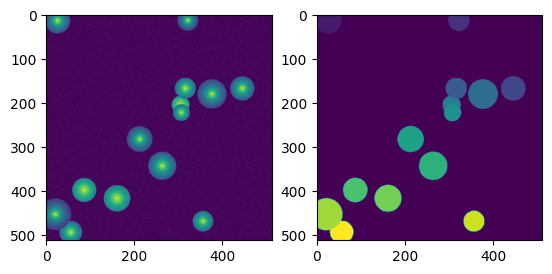

### Incorporating the segmentation into our data set

Now all we need to do is add this new `DataArray` to our existing `DataSet` and the labels and we can rest easy knowing that all our data is safely paired with it's labels.


In [88]:
ds['labels'] = labels

we can also add segmentation metadata into our object so that in the future we know what parameters we used that worked well.

In [99]:
ds.attrs  =ds.attrs | cellpose_options

which leaves us with a nice contained dataset that we can save to disk and inspect in the notebook

In [101]:
# save to a zarr
ds.to_zarr("segmented_experiment.zarr")


# display in the notebook
ds

<xarray.Dataset> Size: 13MB
Dimensions:  (S: 2, X: 512, Y: 512, C: 2, T: 2, Z: 3)
Coordinates:
    Sx       (S) int64 16B 0 512
    Sy       (S) int64 16B 0 512
  * X        (X) float64 4kB 0.0 0.1957 0.3914 0.5871 ... 99.41 99.61 99.8 100.0
  * Y        (Y) float64 4kB 0.0 0.1957 0.3914 0.5871 ... 99.41 99.61 99.8 100.0
  * C        (C) <U3 24B 'BF' 'GFP'
Dimensions without coordinates: S, T, Z
Data variables:
    image    (S, T, C, Z, Y, X) uint16 13MB 218 514 0 0 422 0 ... 0 0 84 0 0 0
Attributes:
    exposure:            5
    channels:            [[0, 0]]
    diameter:            40
    flow_threshold:      0.6
    cellprob_threshold:  -1
    normalize:           False

Note is that even though the shapes of the `labels` and images are different, the labels don't have a `C` dimension, they can still live in the same object. This makes it really easy to compare the segmentation to our original dataset using a tool like [`hyperslicer`](https://mpl-interactions.readthedocs.io/en/stable/examples/hyperslicer.html).


```bash
pip install mpl-interactions

#optionally
pip install ipympl
```

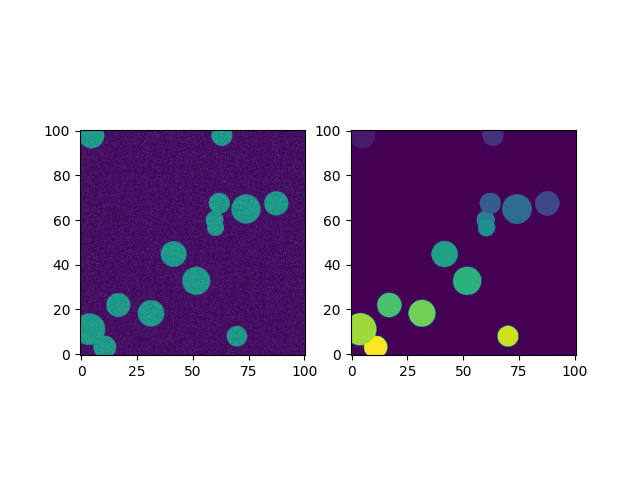

In [89]:
# need this line for interactivity if we are in a notebook
%matplotlib ipympl

from mpl_interactions import hyperslicer

fig, axs = plt.subplots(1,2)
with hyperslicer(ds['image'],ax=axs[0]) as ctrls:
    hyperslicer(ds['labels'],ax=axs[1])

### Extensions


In a future post we will look at how you can leverage `xarray`, `zarr` and `dask` to keep everything running smoothly when your data gets larger. Using those libraries you can split up the data processing into multiple batch jobs that run in parallel and be confident that the jobs won't interfere even when writing to same file on disk.



In [ ]:

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)
axs[0].imshow(normed[0][0])
axs[1].imshow(labels[0][0])


:::{tableofcontents}
:::